In [1]:
import os
os.chdir('/gladstone/engelhardt/home/hvu/source/RNA_rates/splicingrates/simulations')
import pandas as pd
import numpy as np
import seaborn as sns
from experiment import Experiment
from transcripts import Transcript
import visualize_simulations as viz
import matplotlib.pyplot as plt
import simulate_multiple_experiments as sim
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
import helper
ONE_KB=1000
SIM_FEAT_LEN = 5000 # length of one feature in the simulation
SEED = 9999
np.random.seed(SEED)

importing simulate_multiple_experiments


In [2]:
import sys; print(sys.executable)

/gladstone/engelhardt/home/hvu/anaconda3/envs/rna_rate/bin/python


In [3]:
gtf_fn = '/gladstone/engelhardt/home/hvu/source/RNA_rates/KB_Sims_gtfs/ENSG00000006451_ENST00000005257_p0_ptime0_t0.5,4.gtf'
label_time = [0 ,5,10]
num_timepoints = len(label_time)
target_exp = 5
num_total_transcript_millions = 100
degrade_rate = 0.00
intron_h = 5
PAS_h=5
RTR=500
lambda_init = 0.5 # average number of burst events per minute (burst event is the event where a burst_size transcripts are created around the same time)
burst_size = 0 # number of transcripts created in a burst event
wiggle_room = 0.1 # the wiggle room for the burst event. See the comments in function Experiment.init_bursting_transcripts to understand the meaning of this parameter. If not sure, don't modify it.
gtf_df_from_file = sim.read_gtf_file(gtf_fn, intron_h, PAS_h, RTR)
### OR we can create our own controlled gtf_df
gtf_df_control = sim.modify_gtf_df(intron_h=5, PAS_h=5, ex_r_fold=1, in_r_fold=2, ex_length_fold=1, in_length_fold=1)

In [4]:
gtf_df = gtf_df_control
exp_list = sim.generate_exp_given_one_gtf(gtf_df, save_folder= None, label_time = label_time, target_exp=target_exp, num_total_transcript_millions = num_total_transcript_millions, lambda_init = lambda_init , burst_size = burst_size, wiggle_room = wiggle_room)

inside generate_exp_given_one_gtf
before adding new experiments
0
0


ValueError: No objects to concatenate

In [ ]:
# Then, what are the assumptions about this calculation that do not hold anymore in our case?
# Answer the question: Is there a way to calculate the elongation rate based on the read coverage data?
# 4, Then, answer the question: How is splicing half life, elongation rate affecting this? 
# 4, Write down how the cleavage rates were determined in the Pai et al., paper from read data
# 8, Write function to do pull-down of molecules --> basically just a smaller number of timepoints that we are able to observe
# 9, Write function that allows the stopping of transcription initiation

# Is there a way to calculate elongation rates from time-tagged reads (kinetic barcoding)?
We will first try to frame this problem from a traffic flow perspective.
- Create a gtf_df with 3 exons and no introns, with exon2 had double the rate of elongation compare to other exons: done
- Simulate nascent transcripts and reads at t=1, t=2 and t=3: done
- For each timepoint, plot where the transcripts end, and then plot the corresponding time-tagged read coverage

In [5]:
gtf_df = sim.modify_gtf_df(intron_h=5, PAS_h=5, ex_r_fold=2, in_r_fold=1, ex_length_fold=1, in_length_fold=0)
gtf_df = gtf_df[gtf_df['is_intron'] == False]
gtf_df['start'] = gtf_df.loc[0, 'start'] + np.cumsum(gtf_df['length']) - gtf_df['length']
gtf_df['end'] = gtf_df['start'] + gtf_df['length']
gtf_df['time'] = (gtf_df['end'] - gtf_df['start']) / gtf_df['txrate'] / ONE_KB  # time to traverse the feature
exp_list = sim.generate_exp_given_one_gtf(gtf_df, save_folder= None, label_time = label_time, target_exp=target_exp, num_total_transcript_millions = num_total_transcript_millions, lambda_init = lambda_init , burst_size = burst_size, wiggle_room = wiggle_room)

In [22]:
gtf_df

,feature,start,end,length,txrate,is_intron,intron_h,is_PAS,PAS_h,time
0,exon_1,0,5000,5000,1.0,False,0,False,0,5.000
2,exon_2,5000,10000,5000,2.0,False,0,False,0,2.500
4,exon_3,10000,15000,5000,1.0,False,0,False,0,5.000
5,PAS,15000,15001,1,1.0,False,0,True,5,0.001
6,RTR,15001,20001,5000,1.0,False,0,False,0,5.000


            0
position     
0         229
200       121
400       133
600       174
800       165
            0  1
position        
0         239  1
200       109  1
400       158  1
600       185  4
800       162  9
            0  1  2
position           
0         263  1  0
200       115  3  0
400       162  4  0
600       160  4  0
800       163  6  0


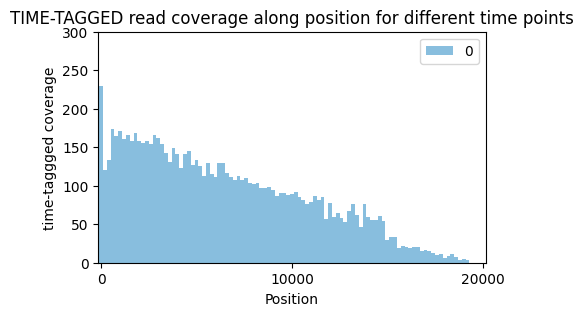

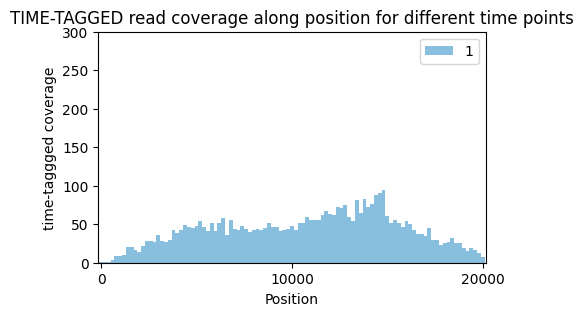

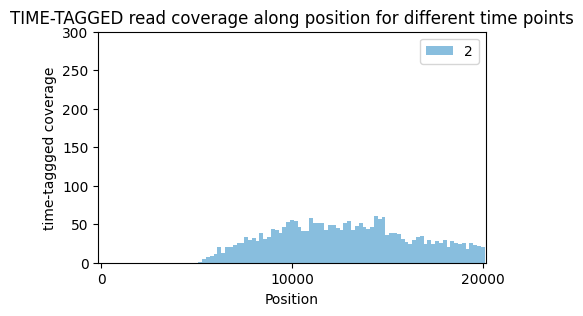

In [29]:
for i in range(len(exp_list)):
    coverage_df = viz.plot_timeTagged_read_coverage(exp_list[:(i+1)], smooth_N=1, gap_N=200, xaxis_N=50, width=1, stacked=False, ylim=(0,300), time_to_plot=range(i,i+1))
    print(coverage_df.head())
    # fig = viz.plot_all_times_endsite(exp_list[:(i+1)], lower_idx=0, upper_idx=720, line_width=2, y_order_by_time=False)

# Create an infrastructure to simulate the experiment under different conditions (different elongation rates, different splicing rates, different cleavage rates)
In order to do so, I need to do the following
- create function save_data for Experiment: done
- create function load_data for Experiment: done
- create function for a baseline gtf_df: done
- create a function that allows me to modify the gtf_df: rates and also length of different features: done
- create function that takes in a gtf_df, and generate exp_list and save those exp_list into folders: done
- create function that generate multiple gtf_df with different elongation rates and exon lengths, and plot the read distribution for each of those gtf_df: done
- Is there a way for me to calculate the elongation rate based on the read coverage data?

In [ ]:
sim.generate_multiple_experiments()

In [32]:
save_folder = '/gladstone/engelhardt/home/hvu/RNA_rates/simulations/'
exon_length_fold = np.arange(1,4)
exon_rate_fold = np.arange(1,4)
exp_list_structure = [[]*len(exon_length_fold)]*len(exon_rate_fold)
for ex_r in exon_rate_fold:
    print('Generating exon_r_fold {}'.format(ex_r))
    for ex_length in exon_length_fold:
        print('Generating ex_length_fold {}'.format(ex_length))
        gtf_df = sim.modify_gtf_df(ex_r_fold=ex_r, ex_length_fold=ex_length) 
        this_save_folder=os.path.join(save_folder, 'exR{ex_r}_exL{ex_length}'.format(ex_r=ex_r, ex_length=ex_length))
        if not os.path.isfile(os.path.join(this_save_folder, 'gtf_df.csv')):
            exp_list = sim.generate_exp_given_one_gtf(gtf_df=gtf_df, save_folder=this_save_folder, label_time=label_time, target_exp=target_exp, num_total_transcript_millions=num_total_transcript_millions, lambda_init=lambda_init , burst_size=burst_size, wiggle_room=wiggle_room)
        # exp_list_structure[ex_r-1][ex_length-1] = exp_list
        # viz.plot_total_read_coverage(exp_list, smooth_N=1, gap_N=200, xaxis_N=50, width=1, ax=axes[ex_r-1,ex_length-1])

Generating exon_r_fold 1
Generating ex_length_fold 1
Generating ex_length_fold 2
Generating ex_length_fold 3
Generating exon_r_fold 2
Generating ex_length_fold 1
Generating ex_length_fold 2
Generating ex_length_fold 3


/gladstone/engelhardt/home/hvu/source/RNA_rates/splicingrates/simulations/simulate_reads_from_transcripts.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  relative_length = np.power(relative_length, 1/delta)


Generating exon_r_fold 3
Generating ex_length_fold 1
Generating ex_length_fold 2
Generating ex_length_fold 3


ValueError: Lengths must match to compare

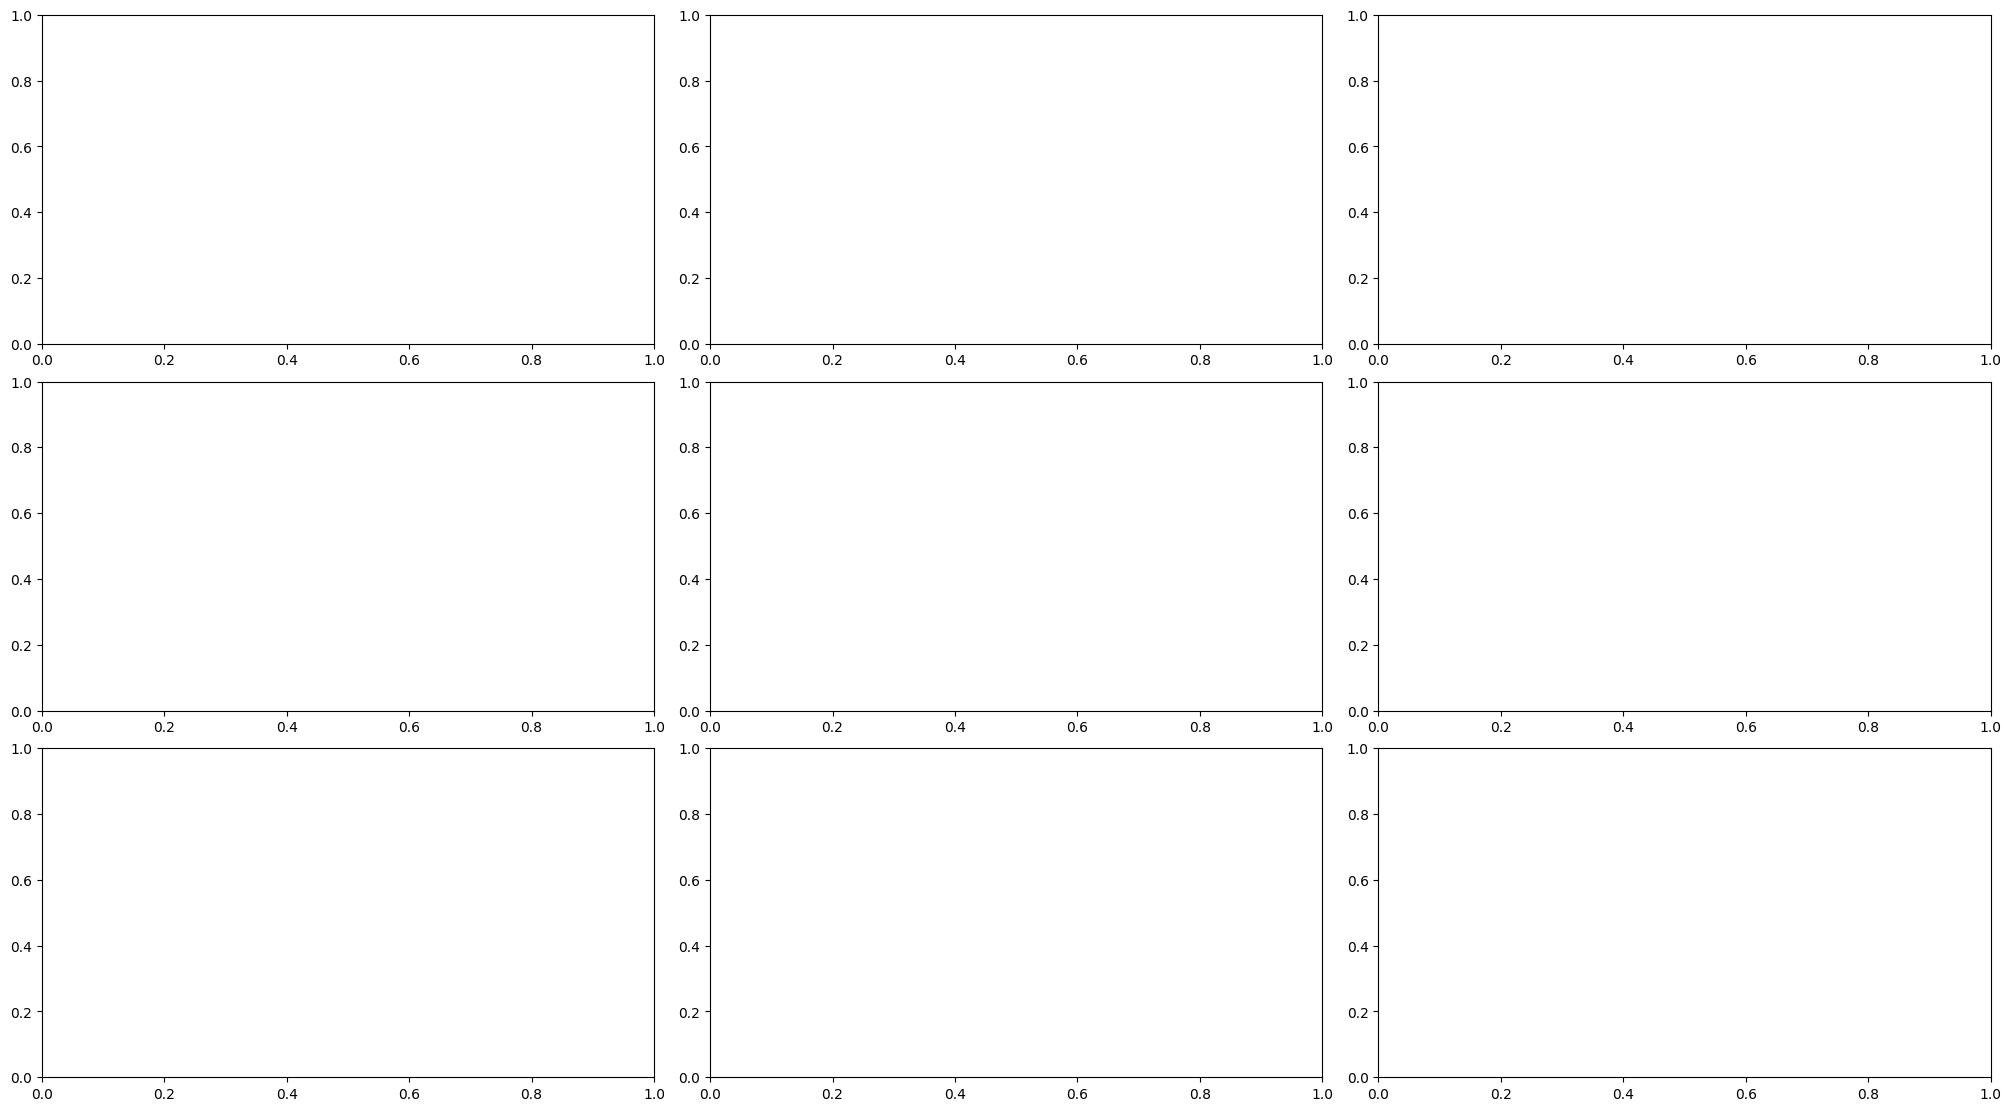

In [41]:
exp_list_structure = [[]*len(exon_length_fold)]*len(exon_rate_fold)
fig, axes = plt.subplots(nrows=len(exon_length_fold), ncols=len(exon_rate_fold), figsize=(6*len(exon_length_fold)+2, 3*len(exon_rate_fold)+2),constrained_layout=True)

for ex_r in exon_rate_fold:
    for ex_length in exon_length_fold:
        exp_list = sim.read_one_exp_sequence(save_folder= os.path.join(save_folder, 'exR{ex_r}_exL{ex_length}'.format(ex_r=ex_r, ex_length=ex_length)))
        this_save_folder = os.path.join(save_folder, 'exR{ex_r}_exL{ex_length}'.format(ex_r=ex_r, ex_length=ex_length))
        # plot_total_read_coverage(exp_list, smooth_N=1, gap_N=200, xaxis_N=50, width=1, ax=axes[ex_r-1,ex_length-1], title='TOTAL coverage: exR{ex_r}_exL{ex_length}'.format(ex_r=ex_r, ex_length=ex_length), save_folder=this_save_folder, grid=False, ylim=(0,300))
        viz.plot_timeTagged_read_coverage(exp_list, smooth_N=1, gap_N=200, xaxis_N=50, width=1, ax=axes[ex_r-1,ex_length-1], title='TIME-TAGGED coverage: exR{ex_r}_exL{ex_length}'.format(ex_r=ex_r, ex_length=ex_length), save_folder=this_save_folder, grid=False, ylim=(0,300))

# How do we calculate splicing rates from the read data?
Splicing rates technically do not need to be calculated using experimental methods fancier than 4su_seq, because the problem formulation allows calculation of splicing halflife from the read data, given that we only harvest transcripts that are elongated in the last X minutes (only one round of metabolic labeling like in 4sU-seq).
First, pull out all the reads that are supposed to be from transcripts that are elongated in the past X minutes. Question: what reads do we pull here? Basically, for each region of the genome, we know approximately how many transcripts that have been elongated during each of the time window.

Given the position of the intron within the gene (U: length from the start of the gene to the start of the intron, I: length of the intron, D: length from the end of the intron to the PAS), and also the elongation rates of WHAT? (intron, run-through-regions, other parts of the gene), we estimate the intron splicing half life using the procedure outlined in Athma's paper. However, here are a few things to note or to answer first:
- In Athma's paper, there is one elongation rate shared throughout every region of the genome. Therefore, the probability that a polymerase end at each position on the genome set to be a uniform distribution. However, in our case, that observation may not be true. 
- The general framework is, if the location of the polymerase is x, then there is an associated probability of intron being spliced based on the transcript end point (where polymerase is). $P(splicing | x) = 1- e^{\frac{x}{h*r}}$, where $h$ and $r$ represent the intron's halflife and elongation rate. At the same time, based on the elongation rates (and what else?), the probability of a polymerase being at a particular position at each moment in time can follow certain distribution (not a constant uniform distribution anymore). We have to intergrate through all the possible values of the polymerase endpoint to calculate the expected proportion of transcripts that are spliced/ unspliced at one point in time. 
- In 4SU experiment, the labeling time point is 5 minute, and that's used to determine the furthest that a transcript can go. Is it still applicable in our case of SLAM-seq experiment? 
- In Athma's paper, was the expeirment being done such that towards the ends, we only obtained the reads that are created in the last 5 minutes? 
- However, in our case, the elongation rate is different for different regions of the genome. Therefore, the probability of splicing at each position is different. P(splicing | x) = f(x, elongation_rate).

# If we calculate splicing half-life based on what Athma Pai did, what would we get?
- At t=3 (or equivalently 15 minutes after t-0), we obaserved a ratio of EE/IE reads ratio. 
- This ratio, according to Pai et al., 2017's paper, equal to $\frac{\frac{hr}{log(2)}(1-2^{-\frac{D+Lr}{hr}})}{D+Lr-\frac{hr}{log(2)}(1-2^{-\frac{D+Lr}{hr}})}$, where 

    - $h$ is the splicing half-life of the intron, i.e. what we are trying to find
    - $r$ is the elongation rate assumed to be uniformed across the gene (which is not true in our case)
    - $D$ is the length between end of intron to the PAS
    - $L$ is the length of the labeling period. In our case, it would be 15 minutes (from t=0 to t=3). 

The natural follow up question is: How did Pai el al., 2017 assume the elongation rate to be? Answer: in section 'Estimating splicing rates from 4sU-RNA-seq data', the method stated that the longation rates are assumed to be constant across the gene, at 1500 nt/min, derived from literature (Ardehali and Lis, 2009, Garcia et al., 2013).

- So, if we take the supposedly observed junction read ratio at t=5, 10,15 minutes based on simulation data, can we calculate $h$? If so, are they consistent across all timepoints (they should be)?


In [ ]:
from scipy.optimize import fsolve

def calculate_spliceH_from_junctRatio(junct_ratio, D, L, r, init_guess:float=100):
    # junct_ratio = EE/EI
    # D = length between end of intron to the PAS
    # L = length of the labeling period (in minutes)
    # r = elongation rate (in nt/min)
    D_prime = D + L*r # the maximum end point of a transcript from the end of this intron during the labelling period
    def func(h_prime):
        return (1 / ((D_prime/h_prime) * (1 - np.exp(-D_prime / h_prime))-1)) - junct_ratio
    h_prime_solution = fsolve(func, init_guess)
    h_prime_solution = h_prime_solution[0]
    h_solution = h_prime_solution* np.log(2) / r 
    return h_solution

In [ ]:
gtf_df

In [ ]:
junctRatio_df['junct_ratio'] = junctRatio_df['ie_reads'] / junctRatio_df['ee_reads']
junctRatio_df

In [ ]:
init_guess = 5
print(calculate_spliceH_from_junctRatio(0.252101, D=15000, L=5, r=1000, init_guess=init_guess))
print(calculate_spliceH_from_junctRatio(0.189873, D=15000, L=10, r=1000, init_guess=init_guess))
print(calculate_spliceH_from_junctRatio(0.097701, D=15000, L=15, r=1000, init_guess=init_guess))

# Plot the junction reads assgined to each timepoint (time-tagged) based on data collected from the last time point (this is what we will observe in real scenario). 

In [ ]:
plot_df = viz.plot_taggedTime_junctions_lastExp(exp_list, feature='intron_1')
# print(plot_df)

In [ ]:
plot_df = viz.plot_taggedTime_junctions_lastExp(exp_list, feature='intron_2')
# print(plot_df)

# 3, Obtain the number of junction reads at each time point (may not be what we observe in real scenario). 

In [ ]:
junctRatio_df = viz.plot_junctreads_over_time(exp_list, feature='intron_1')

In [ ]:
junctRatio_df= viz.plot_junctreads_over_time(exp_list, feature='intron_2')

#  1, Draw the read coverage at each time point and then draw an overlapping read coverage across diffferent time points, like Fig. 2 in the Pai et al., paper

In [ ]:
fig = viz.plot_total_read_coverage(exp_list, smooth_N=1, gap_N=200, xaxis_N=50, width=1)

#  2, Draw the read coverage of the last timepoint, with the read distribution colored by the time point that the read was created
This should simulate the case of Slam-seq, where we label the transcripts at different time points and then sequence them all together
for each read that we harvest in the last time point, we should be able to tell whether it was created/elongated before time point t 
a transcript can be sectioned into segments corresponding to when they were created/elongated

In [ ]:
fig = viz.plot_timeTagged_read_coverage(exp_list, smooth_N=1, gap_N=100, xaxis_N=50)

In [ ]:
gtf_df

In [ ]:
for exp_idx, exp in enumerate(exp_list):
    print(len(exp.transcripts))

In [ ]:
fig = viz.plot_all_times_endsite(exp_list, lower_idx=0, upper_idx=1000, line_width=2, y_order_by_time=True)
fig.show()

In [ ]:
fig = viz.plot_all_times_endsite(exp_list, lower_idx=0, upper_idx=1000, line_width=2, y_order_by_time=False)
fig.show()

In [ ]:
trans_idx = 324
print(exp_list[0].transcripts[trans_idx].endpoint, exp_list[0].transcripts[trans_idx].cleaved_prob, exp_list[0].transcripts[trans_idx].is_cleaved)
print(exp_list[1].transcripts[trans_idx].endpoint, exp_list[1].transcripts[trans_idx].cleaved_prob, exp_list[1].transcripts[trans_idx].is_cleaved)
print(exp_list[2].transcripts[trans_idx].endpoint, exp_list[2].transcripts[trans_idx].cleaved_prob, exp_list[2].transcripts[trans_idx].is_cleaved)
print(exp_list[3].transcripts[trans_idx].endpoint, exp_list[3].transcripts[trans_idx].cleaved_prob, exp_list[3].transcripts[trans_idx].is_cleaved)

# Plot 1: Is the simulation of splicing correct?

Given the transcripts at time points t1 and t2, we plot the splicing status of transcripts at intron_1 at these two time points


In [ ]:
fig = viz.plot_splicing_multiple_timepoints(exp_list, nrows=len(exp_list), ncols=1, max_x=35000, max_y=570, linewidth=2)
fig.show()

# Plot 2: Is the simulation of elongation correct?

Collect all the transcripts that end before i2 at t0, and plot their end points at t1 (do not count newly created transcripts between t0 and t1)

In [ ]:
# right before intron 1, which has txrate 1KB/minute
fig = viz.plot_elongation_two_timepoints(exp_list[0], exp_list[1], (0,5000), sort_values=[0,1])


In [ ]:
# right before intron 2, which has txrate 2KB/min
fig = viz.plot_elongation_two_timepoints(exp_list[2], exp_list[3], (12000,17000), sort_values=[2,3])

## Is the simulation of cleavage correct?

In [ ]:
fig = viz.plot_elongation_two_timepoints(exp_list[0], exp_list[1], (24000,35000), sort_values=[0,1])


In [ ]:
viz.calculate_cleavage_stats(exp_list)

Looking at the statistics reported above, you can see that the proportion of transcript that are uncleaved (but ready to be cleaved, endpoint > PAS_end) at t=i that are then cleaved cleavage_halflife minutes later at t=i+1 is above 0.5, which is NOT what we expect (we were expecting 0.5). I actually went back and investigated the reason for this and found that the concept of half-life, as simulated in our model, is that starting at the moment that the transcript is ready to be cleaved (endpoint=PAS_end), the transcript has a 50% chance of being cleaved in the next cleavage_halflife minutes. This is different from the concept of half-life that we imagine here (with the reported statistics), where the half-life is the time it takes for the number of uncleaved but ready to be cleaved (endpoint>PAS_end instead of endpoint==PAS_end exactly) transcripts to be reduced by half. At t=0, the uncleaved transcripts are uncleaved but their endpoints range from PAS_end to +infinity (more like to RTR_end), therefore, at t=5 minutes (halflife of cleavage), the number of uncleaved transcripts that are cleaved since t=0 is MORE than half of the total number of uncleaved transcripts at t=0. If at t=0, all the uncleaved transcripts have endpoint exactly at PAS_end, then at t=5 minutes, the number of uncleaved transcripts that are cleaved since t=0 is exactly half of the total number of uncleaved transcripts at t=0.

# Visualize the reads

In [ ]:
def plot_read_coverage(reads_df, gtf_df, N=1000):
    # read_coverage = viz.count_read_coverage(reads_df, gtf_df)
    gene_start = gtf_df['start'].iloc[0]
    gene_end = gtf_df['end'].iloc[-1]
    # now plot a bar plot showing the read coverage, x_axis: position along gene, y_axis: number of reads
    plot_df = read_coverage.reset_index()
    plot_df.columns = ['position', 'read_coverage']
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='position', y='read_coverage', data=plot_df)
    plt.xlim(gene_start, gene_end)
    plt.ylabel('Number of reads')
    plt.xlabel('Position along gene')
    plt.title('Read coverage')
    plt.grid(True)
    plt.show()

In [ ]:
plot_read_coverage(reads_df, gtf_df)

# Create plots of function reads at different time points